<h1><center> Study: ER and NR Discrimination </center></h1>

Last Modified: By Daniel Baur on 06th September 2020

This jupyter notebook is used to conduct the ER and NR discrimination study utilizing NESTv2.1.0 .

### Table of Contents


0. **[Stuff](#0.-Stuff)**<br>
    0.1 [Imports](#0.1-Imports)<br>
    0.2 [Infrastructure Definitions](#0.2-Infrastructure-Definitions)<br>


1. **[Detector Parameter Space](#1.-Detector-Parameter-Space)**<br>
    1.0 [Definitions](#1.0-Definitions)<br>
    1.1 [Default Parameters](#1.2-Default-Parameters)<br>
    1.2 [Parameter Sweep](#1.2-Parameter-Sweep)<br>
    1.3 [Printing Parameter Values](#1.3-Printing-Parameter-Values)<br>
    1.4 [Generating Detector Files](#1.4-Generating-Detector-Files)<br>
    1.5 [Determining the Spectra Boundaries](1.5-Determining-the-Spectra-Boundaries)<br>


2. **[Input Spectra](#2.-Input-Spectra)**<br>
    2.0 [General Definitions](#2.0-General-Definitions)<br>
    2.1 [ER Background](#2.1-ER-Background)<br>
    2.2 [WIMPs](#2.2-WIMPs)<br>


3. **[Generating Data](#3.-Data-Generation)**<br>


4. **[Analysis](#4.-Analysis)**<br>
    4.0 [Investigations in Advance](#4.0-Investigations-in-Advance)<br>
    4.1 [Looping over Populations](#4.1-Looping-over-Populations)<br>



# 0. Stuff

## 0.1 Imports

In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('file://' +"/home/daniel/Desktop/arbeitsstuff/20180705__monxe/monxe_software/miscfig/danielsmplstyle.mplstyle")
import numpy as np
from scipy import stats
from scipy.special import binom as binomcoeff
from scipy.optimize import curve_fit
from scipy.integrate import quad
import datetime
import pprint
import itertools
import math
import os
from matplotlib.ticker import AutoMinorLocator
import subprocess
import json

# including the SFS libraries
import sys
sys.path.append("./../../") 
import SF
import SF_spectrum
import SF_detector
import SF_process
import SF_nestcom

# starting a run time measurement
time_i = datetime.datetime.now()


## 0.2 Infrastructure Definitions

In [2]:

# formatting
uni_blue = '#004A9B'
uni_red = '#C1002A'
color_ers = uni_red
color_nrs = uni_blue

# paths
path_data = "./data/"
path_resources = "./resources/"

# flags
flag_delete_data = True # delete all data
flag_generate_detectors = True # generate detector files (ndarrays within 'path_detector')
flag_generate_erbkg_recoil_spectra = True # generate ER spectrum files (ndarrays within 'path_spectrum')
flag_generate_wimp_recoil_spectra = True # generate WIMP recoil spectrum files (ndarrays within 'path_spectrum')
flag_generate_raw_data = True # run NEST in order to generate raw signature data
flag_analysis_extract_discrdata = True # extract discrimination data 
flag_analysis_complots_from_discrdata = True


# optional flags
path_presentationstuff = [
    "",
    path_data +"presentationstuff",
    "/home/daniel/Desktop/arbeitsstuff/20200420__conferences_workshops_excursions/20200909__darwin_collaboration_meeting_2020/talk_sfs/images/"
    ][2]
flag_print_detector_parameters_texhtml = False # detector parameter output (html, latex)
flag_test_spectrum_boundaries = False # to efficiently generate events within the eroi
flag_plot_spectra = False # plotting the differential and absolute ER and NR rate spectra


## 0.3 Preparations

In [3]:
if flag_delete_data == True:
    subprocess.call("rm -r " +path_data +"spectrum/*", shell=True)
    subprocess.call("rm -r " +path_data +"detector/*", shell=True)
    subprocess.call("rm -r " +path_data +"simdata/*", shell=True)
    subprocess.call("rm -r " +path_data +"discrdata/*", shell=True)
    subprocess.call("rm -r " +path_data +"discrplot/*", shell=True)
    subprocess.call("rm -r " +path_data +"complot/*", shell=True)
    subprocess.call("rm -rf ~/.local/share/Trash/*", shell=True) # emptying the trash as simulation data can become relatively huge


# 1. Detector Parameter Space

## 1.0 Definitions

In [4]:

detector_filename = "" # Note that an empty string here is the default. This will not add a detector name to the the saved signature data.


## 1.1 Default Parameters

Within this cell the default detector parameters are defined. If one of the detector parameters is not specified during the simulation the default parameter defined below is used.

In [5]:

# default dictionary
default_detector_parameters = {
    "g1" : 0.119, # phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect
    "sPEres" : 0.38, # single phe resolution (Gaussian assumed)
    "sPEthr" : 0.35, # POD threshold in phe, usually used IN PLACE of sPEeff
    "sPEeff" : 0.90, # actual efficiency, can be used in lieu of POD threshold
    "noise_0_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "noise_1_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "P_dphe" : 0.22, # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT
    "coinWind" : 100, # S1 coincidence window in ns
    "coinLevel" : 3, # how many PMTs have to fire for an S1 to count
    "numPMTs" : 1910, # For coincidence calculation
    # Linear noise" terms as defined in Dahl thesis and by D. McK
    "noise_2_" : 3e-2, # S1 -> S1 Gaussian-smeared with noise[2]*S1
    "noise_3_" : 3e-2, # S2 -> S2 Gaussian-smeared with noise[3]*S2
    # Ionization and Secondary Scintillation (S2) parameters
    "g1_gas" : 0.102, # phd per S2 photon in gas, used to get SE size
    "s2Fano" : 3.61, # Fano-like fudge factor for SE width
    "s2_thr" : 100., # the S2 threshold in phe or PE, *not* phd. Affects NR most
    "E_gas" : 10.85, # field in kV/cm between liquid/gas border and anode
    "eLife_us" : 1600., # the drift electron mean lifetime in micro-seconds
    # Thermodynamic Properties  [if you are getting warnings about being in gas, lower T and/or raise p]
    "inGas" : False, # 
    "T_Kelvin" : 175, # for liquid drift speed calculation
    "p_bar" : 2., # gas pressure in units of bars, it controls S2 size
    # Data Analysis Parameters and Geometry
    "dtCntr" : 822., # center of detector for S1 corrections, in usec.
    "dt_min" : 75.8, # minimum. Top of detector fiducial volume
    "dt_max" : 1536.5, # maximum. Bottom of detector fiducial volume
    "radius" : 1300., # millimeters (fiducial rad)
    "radmax" : 1350., # actual physical geo. limit
    "TopDrift" : 3005.3, # mm not cm or us (but, this *is* where dt=0), a z-axis value of 0 means the bottom of the detector (cathode OR bottom PMTs), In 2-phase, TopDrift=liquid/gas border. In gas detector it's GATE, not anode!
    "anode" : 3012.5, # the level of the anode grid-wire plane in mm, In a gas TPC, this is not TopDrift (top of drift region), but a few mm, above it
    "gate" : 3004.3, # mm. This is where the E-field changes (higher), in gas detectors, the gate is still the gate, but it's where S2 starts
    "cathode" : 404.3, # mm. Defines point below which events are gamma-X
    # 2-D (X & Y) Position Reconstruction
    "PosResExp" : 0.015, # exp increase in pos recon res at hi r, 1/mm
    "PosResBase" : 30., # baseline unc in mm, see NEST.cpp for usage
}


## 1.2 Parameter Sweep

Within the cell below the detector parameter deviating from the default detector parameters are specified. Each parameter name corresponds to a key in the ``darwin_detector_paramter_space`` dictionary. The corresponding key is a list containing the parameter value(s). If more than one parameter is given then the list is swept over.

In [6]:

### parameter sweep profiles

# NEST detector parameters
parameter_list_g1__test = [0.12, 0.16]
parameter_list_g1__kaixuans_suggestion_for_darwin_cm_2020 = [0.12, 0.25]
parameter_list_g1__cm_2020 = [0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24, 0.26]
parameter_list_eLife_us__test = [1000, 2000]
parameter_list_eLife_us__cm_2020 = [1000, 2000, 3000]
parameter_list_eLife_us__kaixuans_suggestion_for_darwin_cm_2020 = [500, 1000, 5000, 10000]

# electrical drift field
paramrange_edrift__kaixuans_suggestion_for_darwin_cm_2020 = [100, 200, 500, 1000, 2000, 5000] # in V/cm
paramrange_edrift__test = [150, 200] # in V/cm
paramrange_edrift__cm_2020 = [200] # in V/cm



### defining the study parameter space

# NEST detector parameters
darwin_detector_parameter_space = {
    "g1" : parameter_list_g1__cm_2020,
    "eLife_us" : parameter_list_eLife_us__cm_2020}

# electrical drift field
paramrange_edrift = paramrange_edrift__cm_2020


## 1.3 OPTIONAL: Printing Parameter Values

This cell is meant to generate LaTeX or html formatted output resembling the ``default_detector_parameters`` dictionary defined above. This output can then be used for the corresponding Wiki note or a LaTeX beamer slide. 

In [7]:
flag_print_detector_parameters_texhtml = True
if flag_print_detector_parameters_texhtml == True:
    
    input_string_default = """
    "g1" : 0.119, # phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect
    "sPEres" : 0.38, # single phe resolution (Gaussian assumed)
    "sPEthr" : 0.35, # POD threshold in phe, usually used IN PLACE of sPEeff
    "sPEeff" : 0.90, # actual efficiency, can be used in lieu of POD threshold
    "noise_0_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "noise_1_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "P_dphe" : 0.22, # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT
    "coinWind" : 100, # S1 coincidence window in ns
    "coinLevel" : 3, # how many PMTs have to fire for an S1 to count
    "numPMTs" : 494, # For coincidence calculation
    # Linear noise" terms as defined in Dahl thesis and by D. McK
    "noise_2_" : 3e-2, # S1 -> S1 Gaussian-smeared with noise[2]*S1
    "noise_3_" : 3e-2, # S2 -> S2 Gaussian-smeared with noise[3]*S2
    # Ionization and Secondary Scintillation (S2) parameters
    "g1_gas" : 0.102, # phd per S2 photon in gas, used to get SE size
    "s2Fano" : 3.61, # Fano-like fudge factor for SE width
    "s2_thr" : 100., # the S2 threshold in phe or PE, *not* phd. Affects NR most
    "E_gas" : 10.85, # field in kV/cm between liquid/gas border and anode
    "eLife_us" : 1600., # the drift electron mean lifetime in micro-seconds
    # Thermodynamic Properties  [if you are getting warnings about being in gas, lower T and/or raise p]
    "inGas" : False, # 
    "T_Kelvin" : 175, # for liquid drift speed calculation
    "p_bar" : 2., # gas pressure in units of bars, it controls S2 size
    # Data Analysis Parameters and Geometry
    "dtCntr" : 822., # center of detector for S1 corrections, in usec.
    "dt_min" : 75.8, # minimum. Top of detector fiducial volume
    "dt_max" : 1536.5, # maximum. Bottom of detector fiducial volume
    "radius" : 1300., # millimeters (fiducial rad)
    "radmax" : 1350., # actual physical geo. limit
    "TopDrift" : 3005., # mm not cm or us (but, this *is* where dt=0), a z-axis value of 0 means the bottom of the detector (cathode OR bottom PMTs), In 2-phase, TopDrift=liquid/gas border. In gas detector it's GATE, not anode!
    "anode" : 3012.5, # the level of the anode grid-wire plane in mm, In a gas TPC, this is not TopDrift (top of drift region), but a few mm, above it
    "gate" : 3000., # mm. This is where the E-field changes (higher), in gas detectors, the gate is still the gate, but it's where S2 starts
    "cathode" : 250, # mm. Defines point below which events are gamma-X
    # 2-D (X & Y) Position Reconstruction
    "PosResExp" : 0.015, # exp increase in pos recon res at hi r, 1/mm
    "PosResBase" : 30., # baseline unc in mm, see NEST.cpp for usage
    """
    
    input_string_sweep = """
    "g1" : [0.11, 0.25], #[0.11, 0.13, 0.15, 0.17],
    "eLife_us" : [500, 1000, 2000], #[1500, 1750, 2000, 2250], # 
    """
    
    print("default detector parameters, html:")
    SF_detector.print_detector_parameters(input_string=input_string_default, input_string_format="default_parameters", output_format="html")
    print("\n")
    print("sweep parameters, html:")
    SF_detector.print_detector_parameters(input_string=input_string_sweep, input_string_format="parameter_sweep", output_format="html")
    print("\n")


default detector parameters, html:
| ''g1'' | 0.119 | phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect |
| ''sPEres'' | 0.38 | single phe resolution (Gaussian assumed) |
| ''sPEthr'' | 0.35 | POD threshold in phe, usually used IN PLACE of sPEeff |
| ''sPEeff'' | 0.90 | actual efficiency, can be used in lieu of POD threshold |
| ''noise_0_'' | 0.0 | baseline noise mean and width in PE (Gaussian) |
| ''noise_1_'' | 0.0 | baseline noise mean and width in PE (Gaussian) |
| ''P_dphe'' | 0.22 | chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT |
| ''coinWind'' | 100 | S1 coincidence window in ns |
| ''coinLevel'' | 3 | how many PMTs have to fire for an S1 to count |
| ''numPMTs'' | 494 | For coincidence calculation |
^ Linear noise" terms as defined in Dahl thesis and by D. McK ^^^
| ''noise_2_'' | 3e-2 | S1 -> S1 Gaussian-smeared with noise[2]*S1 |
| ''noise_3_'' | 3e-2 | S2 -> S2 Gaussian-smeared with noise[3]*S2 |
^ Ionization and Secondary Scintillation (S2) parameters

## 1.4 Generating Detector Files

Within this cell the cartesian product of the utilized parameter space is calculated.

``parameter_sweep_dictionaries``:<br>The keys of this dictionary is a string which contains the deviations from the default detector parameters and the corresponding value is another dictionary containing the whole detector parameters. This dictionary is being looped over when the signature data is being generated:<br>
  (key,val) = (`string_with_deviations_from_default_detector`, `dictionary_with_all_detector_parameters`)

In [8]:
parameter_sweep_dictionaries = {} # this dictionary will contain all detector settings


# computing the cartesion product of the detector parameter space
cartesian_list = {} # from this list the 'update_dicts' will be generated
ctr = 0
for key in darwin_detector_parameter_space.keys():
    cartesian_list.update({key:[]})
    for i in range(len(darwin_detector_parameter_space[key])):
        cartesian_list[key].append([key, darwin_detector_parameter_space[key][i]])
        ctr += 1
parameters_cartesian_product = list(itertools.product(*cartesian_list.values()))


# generating one dictionary containing all the detector parameters including the 
for i in range(len(parameters_cartesian_product)):
    update_param_dict = {parameters_cartesian_product[i][j][0]:parameters_cartesian_product[i][j][1] for j in range(len(parameters_cartesian_product[i]))}
    dictname = ""
    for key in sorted([*update_param_dict]):
        dictname = dictname +key +"_" +SF_detector.numberstring(number_int_float_or_string=update_param_dict[key]) +"_"
    if dictname.endswith("_") :
        dictname = dictname[:-1]
    #update_param_dict = default_detector_parameters.copy().update(**update_param_dict)
    update_param_dict_full = default_detector_parameters.copy()
    update_param_dict_full.update(**update_param_dict)
    parameter_sweep_dictionaries.update({dictname: update_param_dict_full})


# printing the various detector parameter dictionaries that 
flag_print_parameter_sweep_dictionaries = True
if flag_print_parameter_sweep_dictionaries == True:
    for key, val in parameter_sweep_dictionaries.items():
        print(key)
        for k, v in parameter_sweep_dictionaries[key].items():
            print("   ", k, ": ", parameter_sweep_dictionaries[key][k])
        print("")


eLife_us_1000_g1_0_12
    g1 :  0.12
    sPEres :  0.38
    sPEthr :  0.35
    sPEeff :  0.9
    noise_0_ :  0.0
    noise_1_ :  0.0
    P_dphe :  0.22
    coinWind :  100
    coinLevel :  3
    numPMTs :  1910
    noise_2_ :  0.03
    noise_3_ :  0.03
    g1_gas :  0.102
    s2Fano :  3.61
    s2_thr :  100.0
    E_gas :  10.85
    eLife_us :  1000
    inGas :  False
    T_Kelvin :  175
    p_bar :  2.0
    dtCntr :  822.0
    dt_min :  75.8
    dt_max :  1536.5
    radius :  1300.0
    radmax :  1350.0
    TopDrift :  3005.3
    anode :  3012.5
    gate :  3004.3
    cathode :  404.3
    PosResExp :  0.015
    PosResBase :  30.0

eLife_us_2000_g1_0_12
    g1 :  0.12
    sPEres :  0.38
    sPEthr :  0.35
    sPEeff :  0.9
    noise_0_ :  0.0
    noise_1_ :  0.0
    P_dphe :  0.22
    coinWind :  100
    coinLevel :  3
    numPMTs :  1910
    noise_2_ :  0.03
    noise_3_ :  0.03
    g1_gas :  0.102
    s2Fano :  3.61
    s2_thr :  100.0
    E_gas :  10.85
    eLife_us :  2000
    inGa

Within this cell one separate detector header file for each element of the cartesian product is generated.

In [9]:

# looping over all detector configurations
for key, val in parameter_sweep_dictionaries.items():

    # generating the detector header file with the current parameters
    SF_detector.gen_detector_hh_file_from_dict(
        detectorname=detector_filename +key,
        savefolders = [path_data +"detector/"],
        **parameter_sweep_dictionaries[key]
    )



SF_detector: generating eLife_us_1000_g1_0_12.hh.
SF_detector: reading /home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/include/Detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detector/eLife_us_1000_g1_0_12.hh
SF_detector: generating eLife_us_2000_g1_0_12.hh.
SF_detector: reading /home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/include/Detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detector/eLife_us_2000_g1_0_12.hh
SF_detector: generating eLife_us_3000_g1_0_12.hh.
SF_detector: reading /home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/include/Detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detector/eLife_us_3000_g1_0_12.hh
SF_detector: generating eLife_us_1000_g1_0_14.hh.
SF_detector: reading /home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4

## 1.5 OPTIONAL: Determining the Spectra Boundaries

This cell is used to calculate the boundaries (i.e. the maximum recoil energies) for the ER and NR spectra. Hereby it has to be ensured that the maximum NR energy of interest (i.e. ~40keV) yields an S1 that still lies within the examined observable space and that truncating this observable space does not affect the shape of the signatures within it.

In [10]:

if flag_test_spectrum_boundaries == True:
    
    test_spectrum_boundaries_name = "test_spectrum_boundaries"
    test_spectrum_boundaries_g1 = 0.17
    test_spectrum_boundaries_edepmax = 60 # 16
    test_spectrum_boundaries_it = "NR" # "ER"

    # generating the spectrum
    SF_spectrum.gen_gnampfino_parametersweep(
        name = test_spectrum_boundaries_name,
        savefolder = path_spectra,
        number_of_samples_per_run = 10000,
        paramrange_interactiontype = [test_spectrum_boundaries_it],
        paramrange_energydeposition = [test_spectrum_boundaries_edepmax],
        paramrange_edrift = [200]
    )

    # running NEST generating the data
    SF_nestcom.SF_nestcom_runnest(
        filestring_spectrum = path_spectra +test_spectrum_boundaries_name +".npy",
        pathstring_output = path_signatures,
        detectorname = "dummydetector",
        output_pre_string = "test_spectrum_simdata"
    )

    # processing the raw data
    test_spectrum_boundaries_processed_data = SF_process.gen_summarized_ndarray(
        input_folder = path_signatures,
        ndarray = "test_spectrum_simdata__" +test_spectrum_boundaries_name +"__dummydetector.npy",
        output_folder = path_output
    )

    print(f"mean cS1/g1 (e_dep={test_spectrum_boundaries_edepmax}keV_{test_spectrum_boundaries_it}): {test_spectrum_boundaries_processed_data['mean_s1_phe']/test_spectrum_boundaries_g1}")
    print(f"with 1sigma spread: {test_spectrum_boundaries_processed_data['mean_s1_phe_sigma']/test_spectrum_boundaries_g1}")

Running the above simulation for a maximum ER energy of ~16keV_ee and a maximum NR energy of ~60keV_nr yields a cS1/g1 value of ~730 which lies well beyond the mean cS1/g1 value of 450 corresponding to the maximum NR of interest energy of ~40keV.<br>
(Note that the used value for g1 is read out from the NEST output written to the terminal.)<br>
Accordingly I set the ER and NR energy ranges to [0,16] keV_ee and [0,60] keV_nr respectively.

# 2. Input Spectra

## 2.0 Definitions

Within this cell the parameters for the input ER and NR spectra are defined.

In [11]:

# simulation properties
number_of_events_per_population = 1000000 # this is the (approximate) number of particles per spectrum file


# ER background
filename_er_spectrum = f"erbkg_edrift_"
recoilenergyrange_er = [0,16]
numberofbins_er = 64
interactiontype_er = "beta"
er_binwidth = (recoilenergyrange_er[1] -recoilenergyrange_er[0])/numberofbins_er
paramrange_energydeposition_er = np.linspace(num=numberofbins_er, start=recoilenergyrange_er[0]+(0.5*er_binwidth), stop=recoilenergyrange_er[1]-(0.5*er_binwidth), endpoint=True)


# WIMPs
filename_nr_spectrum = f"wimps_edrift_"
recoilenergyrange_nr = [0,60]
numberofbins_nr = 60
interactiontype_nr = "NR"
# paramrange_energydeposition_nr is defined along with the histogram calculation
# WIMP simulation properties
wimpmass = 50 # in GeV
wimpcrosssection = 10**(-47) #1e-47 # in cm^2
activetargetmass = 40 # in tonnes, just relevant for the plots
exposuretime = 5 # in years, just relevant for the plots


## 2.1 ER Background

Within this cell the ER background recoil spectra are defined.

In [12]:

if flag_generate_erbkg_recoil_spectra == True:

    # looping over the 'edirft' parameterspace and generating both er background and wimp recoil spectra
    for i in range(len(paramrange_edrift)):

        # generating the spectrum from the data defined above
        SF_spectrum.gen_gnampfino_parametersweep(
            name = filename_er_spectrum +str(paramrange_edrift[i]),
            savefolder = path_data +"spectrum/",
            number_of_samples_per_run = int(number_of_events_per_population/len(paramrange_energydeposition_er)),
            paramrange_interactiontype = [interactiontype_er],
            paramrange_energydeposition = paramrange_energydeposition_er,
            paramrange_edrift = [paramrange_edrift[i]]
        )


SF_spectrum: saved ndarray 'erbkg_edrift_200.npy' to './data/spectrum/'


## 2.2 WIMPs

Within this cell the input WIMP recoil spectra are generated.

In [13]:

if flag_generate_wimp_recoil_spectra == True:

    # calculating the WIMP recoil spectrum
    paramrange_energydeposition_nr, abs_wimp_recoil_list = SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material(
        mass_wimp_gev = wimpmass,
        cross_section_wimp_proton_cm2 = wimpcrosssection,
        mass_detector_target_t = activetargetmass,
        time_exposure_y = exposuretime,
        energy_threshold_kev = 0,
        energy_nuclear_recoil_min = recoilenergyrange_nr[0],
        energy_nuclear_recoil_max = recoilenergyrange_nr[1],
        number_of_bins_or_samples = numberofbins_nr,
        flag_output = "histogram"
    )

    # calculating the number of events per recoil energy bin
    wimp_recoil_rate_scale_factor = number_of_events_per_population/np.sum(abs_wimp_recoil_list) # making sure approximately the same number of WIMP recoils as ER background events is generated
    events_per_energy_bin_list = np.zeros_like(paramrange_energydeposition_nr)
    for i in range(len(events_per_energy_bin_list)):
        events_per_energy_bin_list[i] = int(abs_wimp_recoil_list[i]*wimp_recoil_rate_scale_factor)
        
    # looping over the 'edirft' parameter space and generating the wimp recoil spectra
    for i in range(len(paramrange_edrift)): # The rates ar of course independent from the drift field. But as those spectra are fed into NEST, the drift field information needs to be taken into account already here.

        # summarize the spectrum data into a tuple list
        wimp_spectrum_tuple_list = []
        for j in range(len(paramrange_energydeposition_nr)):
            wimp_spectrum_tuple_list.append((events_per_energy_bin_list[j], interactiontype_nr, paramrange_energydeposition_nr[j], paramrange_edrift[i], "-1"))

        # generating and saving the wimp recoil spectrum from the tuple list defined above
        wimprecoilspectrum = SF_spectrum.gen_spectrum_ndarray_from_tuplelist(spectrum_tuple_list=wimp_spectrum_tuple_list)
        np.save(path_data +"spectrum/" +filename_nr_spectrum +f"{str(int(paramrange_edrift[i]))}" +".npy", wimprecoilspectrum)


SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material: your relative abundances add up to 100.0 %


## 2.3 Spectra Plotting

absolute ER background rate spectrum

In [14]:
    
if flag_plot_spectra == True:

    data = np.load(path_data +"spectrum/" +filename_er_spectrum +str(paramrange_edrift[0]) +".npy")
    e_er_bin_centers_list_stepized, abs_er_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data["energy_deposition"], counts=data["number_of_events"])

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    #plt.yscale("log")
    y_lim = [0, 1.2*max(data["number_of_events"])]
    ax1.set_xlim(recoilenergyrange_er)
    ax1.set_ylim(y_lim)
    plt.xlabel(r"ER Energy $[\mathrm{keV}_{\mathrm{ee}}]$")
    plt.ylabel(r"Integrated Recoil Rate $[\frac{\mathrm{events}}{" +f"{er_binwidth:.1f}"+"\,\mathrm{keV}_{\mathrm{nr}}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")

    # plotting
    plt.plot(e_er_bin_centers_list_stepized, abs_er_rate_list_stepized, color=uni_blue)
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"total: " +f"{sum(data['number_of_events'])}" +" events", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__er_background_constant_absolute.png")


differential WIMP recoil spectrum in LXe_nat

In [15]:
    
if flag_plot_spectra == True:

    # generating data
    e_nr_list, diff_rate_list = SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material(
        mass_wimp_gev = wimpmass,
        cross_section_wimp_proton_cm2 = wimpcrosssection,
        energy_threshold_kev = 0,
        energy_nuclear_recoil_min = recoilenergyrange_nr[0],
        energy_nuclear_recoil_max = recoilenergyrange_nr[1],
        number_of_bins_or_samples=500,
        flag_output = "rate"
    )

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    plt.yscale("log")
    x_lim = recoilenergyrange_nr
    #y_lim = [1e-10, 1e-6]
    #y_lim = [min(diff_rate_list), 1.2*max(diff_rate_list)]
    ax1.set_xlim(x_lim)
    #ax1.set_ylim(y_lim)
    plt.xlabel(r"NR Energy $[\mathrm{keV}_{\mathrm{nr}}]$")
    plt.ylabel(r"Rate $[\frac{\mathrm{events}}{\mathrm{keV}_{\mathrm{nr}}\times\mathrm{d}\times\mathrm{kg}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")


    # plotting
    plt.plot(e_nr_list, diff_rate_list, color=uni_blue)
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{wimpcrosssection}" +r"\,\mathrm{cm^2}$", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__differential_wimp_recoil_spectrum_in_xenon_nat.png")


combined er and nr recoil spectra

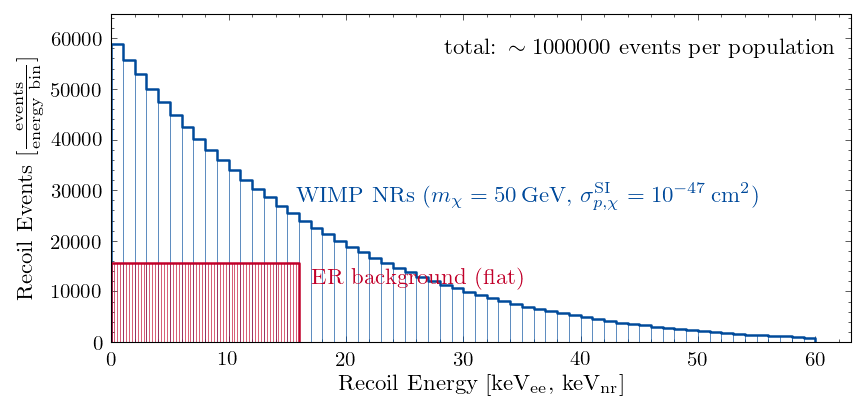

In [16]:
flag_plot_spectra = True          
if flag_plot_spectra == True:

    # nr data
    data_nr = np.load(path_data +"spectrum/" +filename_nr_spectrum +str(paramrange_edrift[0]) +".npy")
    e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data_nr["energy_deposition"], counts=data_nr["number_of_events"])
    e_nr_bin_centers_list_stepized = list(e_nr_bin_centers_list_stepized)
    abs_nr_rate_list_stepized = list(abs_nr_rate_list_stepized)
    noe_nr = 0.5*np.sum(abs_nr_rate_list_stepized)

    # er data
    data_er = np.load(path_data +"spectrum/" +filename_er_spectrum +str(paramrange_edrift[0]) +".npy")
    e_er_bin_centers_list_stepized, abs_er_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data_er["energy_deposition"], counts=data_er["number_of_events"])
    e_er_bin_centers_list_stepized = list(e_er_bin_centers_list_stepized)
    abs_er_rate_list_stepized = list(abs_er_rate_list_stepized)
    noe_er = 0.5*np.sum(abs_er_rate_list_stepized)
    binwidth_er = e_er_bin_centers_list_stepized[2] -e_er_bin_centers_list_stepized[0]

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    x_lim_list = [0,1.05*max(max(e_nr_bin_centers_list_stepized),max(e_er_bin_centers_list_stepized))]
    y_lim_list = [0,1.1*max(max(abs_nr_rate_list_stepized),max(abs_er_rate_list_stepized))]
    ax1.set_xlim(x_lim_list)
    ax1.set_ylim(y_lim_list)
    plt.xlabel(r"Recoil Energy $[\mathrm{keV_{ee}},\,\mathrm{keV_{nr}}]$")
    plt.ylabel(r"Recoil Events $[\frac{\mathrm{events}}{\mathrm{energy\,\,bin}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")

    ### plotting
    # vertical histogram lines
    for i in range(len(e_nr_bin_centers_list_stepized)):
        if (i==0) or (i%2==0):
            plt.plot([e_nr_bin_centers_list_stepized[i], e_nr_bin_centers_list_stepized[i]], [0, abs_nr_rate_list_stepized[i]], linewidth=0.3, color=color_nrs)
    for i in range(len(e_er_bin_centers_list_stepized)):
        if (i==0) or (i%2==0):
            plt.plot([e_er_bin_centers_list_stepized[i], e_er_bin_centers_list_stepized[i]], [0, abs_er_rate_list_stepized[i]], linewidth=0.3, color=color_ers)
    # histogram data
    #e_nr_bin_centers_list_stepized.append(e_nr_bin_centers_list_stepized[len(e_nr_bin_centers_list_stepized)-1])
    #abs_nr_rate_list_stepized.append(0)
    #e_er_bin_centers_list_stepized.append(e_er_bin_centers_list_stepized[len(e_er_bin_centers_list_stepized)-1])
    #abs_er_rate_list_stepized.append(0)
    e_er_bin_centers_list_stepized = [e_er_bin_centers_list_stepized[0]] +e_er_bin_centers_list_stepized +[e_er_bin_centers_list_stepized[len(e_er_bin_centers_list_stepized)-1]]
    abs_er_rate_list_stepized = [0] +abs_er_rate_list_stepized +[0]
    e_nr_bin_centers_list_stepized = [e_nr_bin_centers_list_stepized[0]] +e_nr_bin_centers_list_stepized +[e_nr_bin_centers_list_stepized[len(e_nr_bin_centers_list_stepized)-1]]
    abs_nr_rate_list_stepized = [0] +abs_nr_rate_list_stepized +[0]
    plt.plot(e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized, color=uni_blue)
    plt.plot(e_er_bin_centers_list_stepized, abs_er_rate_list_stepized, color=uni_red)
    # text
    plt.text(x=0.98, y=0.9, transform=ax1.transAxes, s=r"total: $\sim" +f"{number_of_events_per_population}" +"$ events per population", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.text(x=0.98, y=0.9, transform=ax1.transAxes, s=r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{SF_process.exponential_float_to_latex(expfloat=wimpcrosssection)}" +r"\,\mathrm{cm^2}$", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.text(x=0.98, y=0.60, transform=ax1.transAxes, s=r"(flat ER background: $" +f"\sim {abs_er_rate_list_stepized[0]:.0f}" +r"\,\frac{\mathrm{events}}{" +f"{binwidth_er:.2f}" +r"\,\mathrm{keV}}$)", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    plt.text(x=0.25, y=0.40, transform=ax1.transAxes, s=r"WIMP NRs (" +r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{SF_process.exponential_float_to_latex(expfloat=wimpcrosssection)}" +r"\,\mathrm{cm^2}$)", color=uni_blue, fontsize=11, verticalalignment='bottom', horizontalalignment='left')
    plt.text(x=0.27, y=0.16, transform=ax1.transAxes, s=r"ER background (flat)", color=uni_red, fontsize=11, verticalalignment='bottom', horizontalalignment='left')
    #plt.legend()
    plt.show()
    fig.savefig(path_presentationstuff +f"input_recoil_spectrum__er_and_nr_rates_absolute.png")


# 3. Generating Signature Data

Within this cell for every examined detector configuration (i.e. field strength plus detector parameter combination) the following steps are being executed:
* the current detector configuration is implemented
* the ER signature is being simulated using NEST
* the NR signature is being simulated using NEST
The signature data is then saved within the ``./data/signatures/`` folder.

In [17]:

if flag_generate_raw_data == True:

    savelist = []

    ### looping over all possible parameter combinations (edrift and detector parameters)
    for i in range(len(paramrange_edrift)):
        for key, val in parameter_sweep_dictionaries.items():


            # implementing the just generated detector header file into NEST
            SF_nestcom.SF_nestcom_implementdetector(
                filestring_detector = path_data +"detector/" +detector_filename +key +".hh"
            )

            # running NEST with the just adjusted detector and both the ER background and WIMP spectra
            SF_nestcom.SF_nestcom_runnest(
                filestring_spectrum = path_data +"spectrum/" +filename_er_spectrum +str(paramrange_edrift[i]) +".npy",
                pathstring_output = path_data +"simdata/",
                detectorname = detector_filename +key,
                output_pre_string = "simdata"
            )
            #g2_extracted = SF_nestcom.SF_nestcom_runnest(
            SF_nestcom.SF_nestcom_runnest(
                filestring_spectrum = path_data +"spectrum/" +filename_nr_spectrum +str(paramrange_edrift[i]) +".npy",
                pathstring_output = path_data +"simdata/",
                detectorname = detector_filename +key,
                output_pre_string = "simdata"
            )

            # saving the extracted g2 value into 'parameter_sweep_dictionaries'
            #parameter_sweep_dictionaries[key].update(
            #    {"g2_extracted" : g2_extracted}
            #)
            #print(key +" ---> extracted g2: " +str(g2_extracted))



#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detector/eLife_us_1000_g1_0_12.hh' into '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying data of file '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: editing file '/home/daniel/Desktop/arbeitsstuff/20180706__sfs/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: performing a clean re-install
SF_nestcom_implementdetector: performed 'make clean'
SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ te

./../../SF_nestcom.py:206: RuntimeWarning: invalid value encountered in log10
  np.float64(np.log10(np.float64(row[s2_column_id])/np.float64(row[s1_column_id])))


ValueError: could not convert string to float: '-'

# 4. Analysis

## 4.0 OPTIONAL: Investigations in Advance

The cell below is used to investigate the various populations popping up in the cS1/cS2 observable space and gain an understanding regarding their origin.<br>
Hereby a few unphysical populations were identified that correspond to negative (i.e. unphysical) cS1 and cS2 values.

In [ ]:

flag_investigate_populations = False

if flag_investigate_populations == True:

    # defining the parameters (testing)
    param_dict = {
        "edrift" : 750,
        "g1" : 0.15,
        "eLife_us" : 2000
    }

    # loading data
    er_data = np.load(path_input +"simdata__erbkg_edrift_750__g1_0_15_eLife_us_2000.npy")
    nr_data = np.load(path_input +"simdata__wimps_edrift_750__g1_0_15_eLife_us_2000.npy")
    er_s1_over_g1 = np.divide(er_data["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1 = np.log10(np.divide(er_data["s2_phe"], er_data["s1_phe"]))
    nr_s1_over_g1 = np.divide(nr_data["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1 = np.log10(np.divide(nr_data["s2_phe"], nr_data["s1_phe"]))

    # strange data 1: cS1 == cS2 == -10**(-6)
    threshold_s1 = 0.1
    threshold_s2 = 0.1
    er_data_strange_1 = er_data[(er_data["s1_phe"] == -10**(-6)) & (er_data["s2_phe"] == -10**(-6))]
    nr_data_strange_1 = nr_data[(nr_data["s1_phe"] == -10**(-6)) & (nr_data["s2_phe"] == -10**(-6))]
    er_s1_over_g1_strange_1 = np.divide(er_data_strange_1["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_1 = np.log10(np.divide(er_data_strange_1["s2_phe"], er_data_strange_1["s1_phe"]))
    nr_s1_over_g1_strange_1 = np.divide(nr_data_strange_1["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_1 = np.log10(np.divide(nr_data_strange_1["s2_phe"], nr_data_strange_1["s1_phe"]))
    
    # strange data 2: cS1 == -10**(-6) != cS2
    er_data_strange_2 = er_data[(er_data["s1_phe"] == -10**(-6)) & (er_data["s2_phe"] <= 0) & (er_data["s2_phe"] != -10**(-6))]
    nr_data_strange_2 = nr_data[(nr_data["s1_phe"] == -10**(-6)) & (nr_data["s2_phe"] <= 0) & (nr_data["s2_phe"] != -10**(-6))]
    er_s1_over_g1_strange_2 = np.divide(er_data_strange_2["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_2 = np.log10(np.divide(er_data_strange_2["s2_phe"], er_data_strange_2["s1_phe"]))
    nr_s1_over_g1_strange_2 = np.divide(nr_data_strange_2["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_2 = np.log10(np.divide(nr_data_strange_2["s2_phe"], nr_data_strange_2["s1_phe"]))

    # strange data 3: cS1 =! -10**(-6) == cS2
    er_data_strange_3 = er_data[(er_data["s1_phe"] != -10**(-6)) & (er_data["s1_phe"] <= 0) & (er_data["s2_phe"] == -10**(-6))]
    nr_data_strange_3 = nr_data[(nr_data["s1_phe"] != -10**(-6)) & (nr_data["s1_phe"] <= 0) & (nr_data["s2_phe"] == -10**(-6))]
    er_s1_over_g1_strange_3 = np.divide(er_data_strange_3["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_3 = np.log10(np.divide(er_data_strange_3["s2_phe"], er_data_strange_3["s1_phe"]))
    nr_s1_over_g1_strange_3 = np.divide(nr_data_strange_3["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_3 = np.log10(np.divide(nr_data_strange_3["s2_phe"], nr_data_strange_3["s1_phe"]))

    # strange data 4: cS1 =! -10**(-6) != cS2
    er_data_strange_4 = er_data[(er_data["s1_phe"] != -10**(-6)) & (er_data["s1_phe"] <= 0) & (er_data["s2_phe"] != -10**(-6)) & (er_data["s2_phe"] <= 0)]
    nr_data_strange_4 = nr_data[(nr_data["s1_phe"] != -10**(-6)) & (nr_data["s1_phe"] <= 0) & (nr_data["s2_phe"] != -10**(-6)) & (nr_data["s2_phe"] <= 0)]
    er_s1_over_g1_strange_4 = np.divide(er_data_strange_4["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_4 = np.log10(np.divide(er_data_strange_4["s2_phe"], er_data_strange_4["s1_phe"]))
    nr_s1_over_g1_strange_4 = np.divide(nr_data_strange_4["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_4 = np.log10(np.divide(nr_data_strange_4["s2_phe"], nr_data_strange_4["s1_phe"]))

    # modified data
    er_data_mod = er_data[(er_data["s1_phe"] >= 0) & (er_data["s2_phe"] >= 0)]
    nr_data_mod = nr_data[(nr_data["s1_phe"] >= 0) & (nr_data["s2_phe"] >= 0)]
    er_s1_over_g1_mod = np.divide(er_data_mod["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_mod = np.log10(np.divide(er_data_mod["s2_phe"], er_data_mod["s1_phe"]))
    nr_s1_over_g1_mod = np.divide(nr_data_mod["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_mod = np.log10(np.divide(nr_data_mod["s2_phe"], nr_data_mod["s1_phe"]))
   
    # investigating strange populations
    print("strange populations:")
    print(er_data.dtype.names)
    threshold = 5
    investigation_data_er = er_data[(er_data["s1_phe"]<=threshold) & (er_data["s1_phe"]>=threshold) & (er_data["s2_phe"]<=threshold) & (er_data["s2_phe"]>=threshold)]
    for i in range(len(investigation_data_er)):
        print(investigation_data_er[i])

    ### plotting
    # formatting
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    #ax1.set_xlim([0,500])
    #ax1.set_ylim([2,3.75])
    plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{PE}]$")
    plt.ylabel(r"$\mathrm{log}_{10}\left(\frac{cS2}{cS1}\right)$")
    # plotting data
    plt.text(x=0.45, y=0.70, s=r"ER Background", transform=ax1.transAxes, color=color_ers, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1, y=er_log10_s2_over_s1, s=4, facecolor=color_ers, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
    plt.text(x=0.45, y=0.55, s=r"WIMP NRs", transform=ax1.transAxes, color=color_nrs, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=nr_s1_over_g1, y=nr_log10_s2_over_s1, s=4, facecolor=color_nrs, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
    color_strange_1 = "green"
    plt.text(x=0.07, y=0.44, s=r"$cS1 = cS2 = -10^{-6}$", transform=ax1.transAxes, color=color_strange_1, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_1, y=er_log10_s2_over_s1_strange_1, s=4, facecolor=color_strange_1, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_1, y=nr_log10_s2_over_s1_strange_1, s=4, facecolor=color_strange_1, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_2 = "cyan"
    plt.text(x=0.07, y=0.91, s=r"$cS1 = -10^{-6} \neq cS2$", transform=ax1.transAxes, color=color_strange_2, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_2, y=er_log10_s2_over_s1_strange_2, s=4, facecolor=color_strange_2, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_2, y=nr_log10_s2_over_s1_strange_2, s=4, facecolor=color_strange_2, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_3 = "orange"
    plt.text(x=0.07, y=0.11, s=r"$cS1 \neq -10^{-6} = cS2$", transform=ax1.transAxes, color=color_strange_3, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_3, y=er_log10_s2_over_s1_strange_3, s=4, facecolor=color_strange_3, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_3, y=nr_log10_s2_over_s1_strange_3, s=4, facecolor=color_strange_3, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_4 = "purple"
    plt.text(x=0.07, y=0.57, s=r"$cS1 \neq -10^{-6} \neq cS2$", transform=ax1.transAxes, color=color_strange_4, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_4, y=er_log10_s2_over_s1_strange_4, s=4, facecolor=color_strange_4, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_4, y=nr_log10_s2_over_s1_strange_4, s=4, facecolor=color_strange_4, marker=".", alpha=1, linewidths=0, edgecolors=None)
    #plt.legend()
    # saving
    plt.show()
    savename = "investigating_strange_populations_"
    savestring = ""
    for key, val in param_dict.items():
        savestring = savestring +"_" +key +"_" +str(val).replace(".","_")
    fig.savefig(path_output_presentationstuff +name_presentation +"__" +savename +".png")
    fig.savefig(path_presentation +name_presentation +"__" +".png")


Conclusion:<br>
Apparently some events (preferrably lower energetic ones) yield negative and strange S1 and/or S2 signatures within NEST (probably due to threshold effects). If only either of the S1 and S2 values is negative, then the argument of 'np.log10' is negative and 'np.log10' evaluates to 'NaN'; those events are not plotted at all. If both S1 and S2 are negative, the the argument of 'np.log10' is positive again. Nevertheless these events are considered neglected. Furthermore '-10**(-6)' appears to be some relevant default return value. In the plot above the various discarded populations have been identified. In order to discard those events it is sufficient to just process events with S1 and S2 values greater than 0.

## 4.1 Generating `discrdata` from `simdata`

For every detector configuration (i.e. drift field +NEST detector file) the corresponding signature data (i.e. ER background +WIMP spectrum) is examined. The data extracted from each of those detector configuration is then displayed within poplot and saved as a ndarray. 



In [ ]:

### pop analysis settings 

# energy bins
eroi = [1, 11] # in keV_ee
analysis_bin_edges = np.linspace(
    num = 50+1, # number of E_ee bins/slices
    start = eroi[0], # E_ee min
    stop = eroi[1], # E_ee max
    endpoint = True)
analysis_bin_width = analysis_bin_edges[1] -analysis_bin_edges[0]
nr_acceptance_scan = [30, 50, 85] # list of NR acceptances (in %) to be scanned
flag_dataslicing = ["s1_g1", "er_ee"][1]

# formatting
observable_range = [0,500]
observable_range_number_of_bins = 50
observable_range_bin_edges = np.linspace(num=observable_range_number_of_bins, start=observable_range[0], stop=observable_range[1], endpoint=True)
leakage_fraction_percentile = 85 # e.g. 50: for an ER event to be considered 'leaking' it has to be 'lower' than 50 percent of the NR events within that bin.
threshold_events_per_bin = 60

# debugging
ctr = 0
ctr_threshold = 1000 # to restrict runtime

labelstring_dict = {
    "edrift" : [r"$E_{\mathrm{drift}}$", r"$\mathrm{\frac{V}{cm}}$", "Electrical Drift Field"],
    "g1" : [r"$g_1$", r"$\mathrm{\frac{phd}{ph}}$", r"PDE in LXe"],
    "eLife_us" : [r"$\tau_{e}$", r"$\mu \mathrm{s}$", "Electron Lifetime"],}



### pop analysis

flag_analysis_extract_discrdata = True
if flag_analysis_extract_discrdata == True:

    # looping over every ER/NR signature data pair and over every NR acceptance value
    for i in range(len(paramrange_edrift)):
        for key, val in parameter_sweep_dictionaries.items():
            if ctr <= ctr_threshold:

                # loading the signature data and cutting the events with negative S1 and S2 values
                er_data_string = SF_process.search_for_filestring(
                    path = path_data +"simdata/",
                    include_list = ["simdata", filename_er_spectrum +str(paramrange_edrift[i]), key, ".npy"],
                    exclude_list = [])
                nr_data_string = SF_process.search_for_filestring(
                    path = path_data +"simdata/",
                    include_list = ["simdata", filename_nr_spectrum +str(paramrange_edrift[i]), key, ".npy"],
                    exclude_list = [])
                #er_data = np.load(path_data +"simdata/simdata__" +filename_er_spectrum +str(paramrange_edrift[i]) +"__" +key +".npy")
                #nr_data = np.load(path_data +"simdata/simdata__" +filename_nr_spectrum +str(paramrange_edrift[i]) +"__" +key +".npy")
                er_data = np.load(er_data_string)
                nr_data = np.load(nr_data_string)
                er_data_cut = er_data[(er_data["s1_phe"] >= 0) & (er_data["s2_phe"] >= 0)]
                nr_data_cut = nr_data[(nr_data["s1_phe"] >= 0) & (nr_data["s2_phe"] >= 0)]
                #g2_extracted = SF_process.get_parameter_val_from_filename(filename = er_data_string, parametername = "g2")
                g2_extracted = SF_process.get_parameter_val_from_filename(filename = er_data_string, parametername = "g2")

                # actual analysis: selecting sliced data and generating popdata, discrimination line and sliced data
                popdata_ndarray, nr_data_sliced, er_data_sliced = SF_process.get_discrdata_from_simdata(
                    input_er_data = er_data_cut,
                    input_nr_data = nr_data_cut,
                    bin_edges = analysis_bin_edges,
                    threshold_events_per_bin = 20,
                    nr_acceptances = nr_acceptance_scan,
                    savestring = path_data +"discrdata/discrdata__edrift_" +f"{paramrange_edrift[i]}_" +key +".npy",
                    flag_slicing = flag_dataslicing,
                    flag_returnsubdatasets = True,
                    **{
                        "g1" : parameter_sweep_dictionaries[key]["g1"],
                        "g2" : g2_extracted,
                        "w" : SF.W,
                    }
                )

                # generate one plot for every investigated nr acceptance
                for nracc in nr_acceptance_scan:
                    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                    ax1.set_xlim(observable_range)
                    x_lim = [np.min([min(er_data_sliced[i]["s1_phe"]) for i in range(len(er_data_sliced))])/parameter_sweep_dictionaries[key]["g1"], 1.05*np.max([max(nr_data_sliced[i]["s1_phe"]) for i in range(len(nr_data_sliced))])/parameter_sweep_dictionaries[key]["g1"]]
                    y_lim = [np.min([np.min(nr_data_sliced[i]["log_s2_s1"]) for i in range(len(nr_data_sliced))]), np.max([np.max(er_data_sliced[i]["log_s2_s1"]) for i in range(len(er_data_sliced))])]
                    ax1.set_xlim(x_lim)
                    ax1.set_ylim(y_lim)
                    plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{ph}]$")
                    plt.ylabel(r"$\mathrm{log}_{10}\left(\frac{cS2}{cS1}\right)$")

                    # plotting excluded data
                    plt.scatter(
                        x = (1/parameter_sweep_dictionaries[key]["g1"])*er_data_cut["s1_phe"],
                        y = er_data_cut["log_s2_s1"],
                        s = 4,
                        facecolor = "#d6d6d4", # light light grey,
                        marker = ".",
                        alpha = 0.05,
                        linewidths = 0,
                        edgecolors = None)
                    plt.scatter(
                        x = (1/parameter_sweep_dictionaries[key]["g1"])*nr_data_cut["s1_phe"],
                        y = nr_data_cut["log_s2_s1"],
                        s = 4,
                        facecolor = "#a6a6a4", # light dark grey
                        marker = ".",
                        alpha = 0.05,
                        linewidths = 0,
                        edgecolors = None)

                    # plotting selected data
                    for j in range(len(er_data_sliced)): # plot er data first in order to avoid artifacts
                        plt.scatter(x=(1/parameter_sweep_dictionaries[key]["g1"])*er_data_sliced[j]["s1_phe"], y=er_data_sliced[j]["log_s2_s1"], s=4, facecolor=color_ers, marker=".", alpha=0.05, linewidths=0, edgecolors=None)
                    for j in range(len(er_data_sliced)):
                        plt.scatter(x=(1/parameter_sweep_dictionaries[key]["g1"])*nr_data_sliced[j]["s1_phe"], y=nr_data_sliced[j]["log_s2_s1"], s=4, facecolor=color_nrs, marker=".", alpha=0.05, linewidths=0, edgecolors=None)

                    # plotting energy contours
                    energy_contour_list = np.linspace(num=5+1, start=eroi[0], stop=eroi[1], endpoint=True)
                    for j in range(len(energy_contour_list)):
                        flag_printeval = True
                        if j == len(energy_contour_list)-1:
                            flag_printeval = False
                        SF_process.draw_energy_contour_line(
                            ax = ax1,
                            param_e_keV = energy_contour_list[j], # in keV
                            param_g1 = parameter_sweep_dictionaries[key]["g1"],
                            param_g2 = g2_extracted,
                            param_w = SF.W,
                            number_of_samples = 150,
                            fmt_color = "#6e6e6d", ##8c8c8b",
                            fmt_rel_annotation_height_y = 0.04,
                            fmt_linewidth = 0.8,
                            fmt_fontsize = 6,
                            fmt_x_offset = 0.01,
                            flag_annotateenergyval = flag_printeval)

                    # plotting the discrimination line (via double list comprehension)
                    discrimination_line_data_x = [popdata_ndarray[j][i] for i in range(len(popdata_ndarray)) for j in ["nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"discriminationline_x_left", "nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"discriminationline_x_right"]]
                    discrimination_line_data_y = [popdata_ndarray[j][i] for i in range(len(popdata_ndarray)) for j in ["nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"threshold_value", "nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"threshold_value"]]
                    plt.plot(
                        discrimination_line_data_x,
                        discrimination_line_data_y,
                        color = "black",
                        linewidth = 0.8)

                    # printing annotations
                    plt.text( # er signature
                        x = 0.08,
                        y = 0.79,
                        transform = ax1.transAxes,
                        s = r"ER background (flat)",
                        color = color_ers,
                        fontsize = 11,
                        verticalalignment = 'center',
                        horizontalalignment='left')
                    plt.text( # wimp signature
                        x = 0.11,
                        y = 0.15,
                        transform = ax1.transAxes,
                        s = r"WIMP NRs ($m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$)",
                        color = color_nrs,
                        fontsize = 11,
                        verticalalignment = 'center',
                        horizontalalignment = 'left')
                    parameter_vertical_linespacing = 0.1
                    parameter_pos_x = 0.98
                    parameter_pos_y = 0.89
                    parameter_pos_ctr = 1
                    plt.text( # drift field
                        x=parameter_pos_x,
                        y=parameter_pos_y,
                        transform=ax1.transAxes,
                        s = labelstring_dict["edrift"][0] +"$=" +f"{paramrange_edrift[i]}" +"\,$" +labelstring_dict["edrift"][1],
                        color="black",
                        fontsize = 11,
                        verticalalignment='center',
                        horizontalalignment='right')
                    for k, v in parameter_sweep_dictionaries[key].items(): # other detector parameters
                        if k in key:
                            plt.text(
                                x=parameter_pos_x,
                                y=parameter_pos_y -parameter_pos_ctr*parameter_vertical_linespacing,
                                transform=ax1.transAxes,
                                s = labelstring_dict[k][0] +"$=" +f"{v}" +"\,$" +labelstring_dict[k][1],
                                color="black",
                                fontsize=11,
                                verticalalignment='center',
                                horizontalalignment='right')
                            parameter_pos_ctr += 1
                    total_rejection, total_rejection_error = SF_process.calc_total_rejection_from_discrdata( # calculating the toal rejection
                        input_popdata = popdata_ndarray,
                        nr_acceptance = nracc,
                        flag_definition = [
                            "total_number_of_ers_above_discrimination_line",
                            "number_of_ers_above_discrimination_line_weighted_by_nrs_in_bin"]
                            [0])
                    plt.text( # discrimination line
                        x = 0.30,
                        y = (discrimination_line_data_y[int(0.3*len(discrimination_line_data_x))]-y_lim[0])/(y_lim[1]-y_lim[0]) +0.02,
                        transform = ax1.transAxes,
                        s = r"Discrimination Line $R^{\mathrm{tot}}(A=" +f"{nracc:.1f}" +r"\,\%)=" +f"{total_rejection:.2f}" +r"\,\%$",
                        color="black",
                        fontsize=11,
                        verticalalignment='center',
                        horizontalalignment='left')
                    #plt.legend()

                    # saving the plot
                    savestring = "__edrift_" +f"{paramrange_edrift[i]}"
                    for k, v in val.items():
                        if k in key:
                            savestring = savestring +"_" +k +"_" +str(v).replace(".","_")
                    savestring = savestring +"__" +"nracc_" +f"{nracc:.1f}".replace(".","_")
                    fig.savefig(path_data +"discrplot/discrplot__" +savestring +".png")
                    plt.close(fig)
                    ctr += 1





### outreach output

                    # plotting for presentations
                    if path_presentationstuff != "" and nracc == 30 and (paramrange_edrift[i] == 200) and (key == "eLife_us_2000_g1_0_16"):

                        # definitions
                        presentation_savestring = "sigplot_explanation"
                        presentation_modes = ["populate_observable_space", "bin_data", "calculate_discrimination"]
                        
                        # looping over 'presentation_modes'
                        for m in range(len(presentation_modes)):

                            # preparing plot
                            fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                            x_lim = [np.min([min(er_data_sliced[i]["s1_phe"]) for i in range(len(er_data_sliced))])/parameter_sweep_dictionaries[key]["g1"], 1.05*np.max([max(nr_data_sliced[i]["s1_phe"]) for i in range(len(nr_data_sliced))])/parameter_sweep_dictionaries[key]["g1"]]
                            y_lim = [np.min([np.min(nr_data_sliced[i]["log_s2_s1"]) for i in range(len(nr_data_sliced))]), np.max([np.max(er_data_sliced[i]["log_s2_s1"]) for i in range(len(er_data_sliced))])]
                            ax1.set_xlim(x_lim)
                            ax1.set_ylim(y_lim)
                            plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{ph}]$")
                            plt.ylabel(r"$\mathrm{log}_{10}\left(\frac{cS2}{cS1}\right)$")

                            # plotting excluded data
                            if presentation_modes[m] in ["populate_observable_space"]:
                                ercolor = color_ers
                                nrcolor = color_nrs
                            else:
                                ercolor = "#d6d6d4"
                                nrcolor = "#a6a6a4"
                            plt.scatter(
                                x = (1/parameter_sweep_dictionaries[key]["g1"])*er_data_cut["s1_phe"],
                                y = er_data_cut["log_s2_s1"],
                                s = 4,
                                facecolor = ercolor,
                                marker = ".",
                                alpha = 0.05,
                                linewidths = 0,
                                edgecolors = None)
                            plt.scatter(
                                x = (1/parameter_sweep_dictionaries[key]["g1"])*nr_data_cut["s1_phe"],
                                y = nr_data_cut["log_s2_s1"],
                                s = 4,
                                facecolor = nrcolor,
                                marker = ".",
                                alpha = 0.05,
                                linewidths = 0,
                                edgecolors = None)

                            # plotting selected data
                            if presentation_modes[m] in ["bin_data", "calculate_discrimination"]:
                                for j in range(len(er_data_sliced)): # plot er data first in order to avoid artifacts
                                    plt.scatter(x=(1/parameter_sweep_dictionaries[key]["g1"])*er_data_sliced[j]["s1_phe"], y=er_data_sliced[j]["log_s2_s1"], s=4, facecolor=color_ers, marker=".", alpha=0.05, linewidths=0, edgecolors=None)
                                for j in range(len(er_data_sliced)):
                                    plt.scatter(x=(1/parameter_sweep_dictionaries[key]["g1"])*nr_data_sliced[j]["s1_phe"], y=nr_data_sliced[j]["log_s2_s1"], s=4, facecolor=color_nrs, marker=".", alpha=0.05, linewidths=0, edgecolors=None)

                            # plotting energy contours
                            if presentation_modes[m] in ["bin_data", "calculate_discrimination"]:
                                energy_contour_list = np.linspace(num=5+1, start=eroi[0], stop=eroi[1], endpoint=True)
                                for j in range(len(energy_contour_list)):
                                    flag_printeval = True
                                    if j == len(energy_contour_list)-1:
                                        flag_printeval = False
                                    SF_process.draw_energy_contour_line(
                                        ax = ax1,
                                        param_e_keV = energy_contour_list[j], # in keV
                                        param_g1 = parameter_sweep_dictionaries[key]["g1"],
                                        param_g2 = g2_extracted,
                                        param_w = SF.W,
                                        number_of_samples = 150,
                                        fmt_color = "#6e6e6d", ##8c8c8b",
                                        fmt_rel_annotation_height_y = 0.04,
                                        fmt_linewidth = 0.8,
                                        fmt_fontsize = 6,
                                        fmt_x_offset = 0.01,
                                        flag_annotateenergyval = flag_printeval)

                            # plotting the discrimination line (via double list comprehension)
                            if presentation_modes[m] in ["calculate_discrimination"]:
                                discrimination_line_data_x = [popdata_ndarray[j][i] for i in range(len(popdata_ndarray)) for j in ["nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"discriminationline_x_left", "nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"discriminationline_x_right"]]
                                discrimination_line_data_y = [popdata_ndarray[j][i] for i in range(len(popdata_ndarray)) for j in ["nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"threshold_value", "nracc_" +f"{nracc:.1f}".replace(".","_") +"__" +"threshold_value"]]
                                plt.plot(
                                    discrimination_line_data_x,
                                    discrimination_line_data_y,
                                    color = "black",
                                    linewidth = 0.8)

                            # printing annotations
                            plt.text( # er signature
                                x = 0.08,
                                y = 0.79,
                                transform = ax1.transAxes,
                                s = r"ER background (flat)",
                                color = color_ers,
                                fontsize = 11,
                                verticalalignment = 'center',
                                horizontalalignment='left')
                            plt.text( # wimp signature
                                x = 0.11,
                                y = 0.15,
                                transform = ax1.transAxes,
                                s = r"WIMP NRs ($m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$)",
                                color = color_nrs,
                                fontsize = 11,
                                verticalalignment = 'center',
                                horizontalalignment = 'left')
                            parameter_vertical_linespacing = 0.1
                            parameter_pos_x = 0.98
                            parameter_pos_y = 0.89
                            parameter_pos_ctr = 1
                            plt.text( # drift field
                                x=parameter_pos_x,
                                y=parameter_pos_y,
                                transform=ax1.transAxes,
                                s = labelstring_dict["edrift"][0] +"$=" +f"{paramrange_edrift[i]}" +"\,$" +labelstring_dict["edrift"][1],
                                color="black",
                                fontsize = 11,
                                verticalalignment='center',
                                horizontalalignment='right')
                            for k, v in parameter_sweep_dictionaries[key].items(): # other detector parameters
                                if k in key:
                                    plt.text(
                                        x=parameter_pos_x,
                                        y=parameter_pos_y -parameter_pos_ctr*parameter_vertical_linespacing,
                                        transform=ax1.transAxes,
                                        s = labelstring_dict[k][0] +"$=" +f"{v}" +"\,$" +labelstring_dict[k][1],
                                        color="black",
                                        fontsize=11,
                                        verticalalignment='center',
                                        horizontalalignment='right')
                                    parameter_pos_ctr += 1
                            total_rejection, total_rejection_error = SF_process.calc_total_rejection_from_discrdata( # calculating the toal rejection
                                input_popdata = popdata_ndarray,
                                nr_acceptance = nracc,
                                flag_definition = [
                                    "total_number_of_ers_above_discrimination_line",
                                    "number_of_ers_above_discrimination_line_weighted_by_nrs_in_bin"]
                                    [0])
                            if presentation_modes[m] in ["calculate_discrimination"]:
                                plt.text( # discrimination line
                                    x = 0.30,
                                    y = (discrimination_line_data_y[int(0.3*len(discrimination_line_data_x))]-y_lim[0])/(y_lim[1]-y_lim[0]) +0.02,
                                    transform = ax1.transAxes,
                                    s = r"Discrimination Line $R^{\mathrm{tot}}(A=" +f"{nracc:.1f}" +r"\,\%)=" +f"{total_rejection:.2f}" +r"\,\%$",
                                    color="black",
                                    fontsize=11,
                                    verticalalignment='center',
                                    horizontalalignment='left')

                            # saving
                            savestring = "sigplot_explanation__" +str(m+1) +"_" +presentation_modes[m] +".png"
                            fig.savefig(path_presentationstuff +savestring)
                            plt.close(fig)



## 4.2 Generating `complot`s from `discrdata`

The aim of the analysis code within this cell is meant to investigate the dependance of the ER rejection (i.e. per bin or total) on the detector parameters.

#### Generating the `cumulative_investigation_dictionary`

In order to investigate the influence of one specific parameter $p$ (either on the ER rejection per bin or in total) all the others need to be fixed. Therefore the `cumulative_investigation_dictionary` contains collections of `discrdata` filenames corresponding to datasets of a fixed parameter set that only differ in the parameter $p$ to be investigated. In order to load the corresponding data one only needs to loop over the entries of the `cumulative_investigation_dictionary`.


In [ ]:

### defining a dictionary containing all parameters to be looped over (i.e. inc. 'edrift')
parameter_dictionary = darwin_detector_parameter_space.copy()
parameter_dictionary.update({"edrift" : paramrange_edrift})

### defining the output 'cumulative_investigation_dictionary'
cumulative_investigation_dictionary = parameter_dictionary.copy()
for key, val in cumulative_investigation_dictionary.items():
    cumulative_investigation_dictionary[key] = {}

### looping over all 'investigation_parameter's and and generating the 'cartesian_list'
### containing every possible combination of static parameter values for this specific 'investigation_parameter'
for investigation_parameter in ["edrift"] +[*darwin_detector_parameter_space]:
    # generating a dictionary containing all keys but the current 'investigation_parameter'
    parameter_dictionary_without_investigation_parameter = parameter_dictionary.copy()
    parameter_dictionary_without_investigation_parameter.pop(investigation_parameter)
    # generating 'cartesian_list'
    cartesian_list = {}
    for key in parameter_dictionary_without_investigation_parameter.keys():
        cartesian_list.update({key:[]})
        for i in range(len(parameter_dictionary_without_investigation_parameter[key])):
            cartesian_list[key].append([key, parameter_dictionary_without_investigation_parameter[key][i]])
    parameters_cartesian_product = list(itertools.product(*cartesian_list.values()))
    cartesian_list = []
    for i in range(len(parameters_cartesian_product)):
        append_dict = {}
        for j in range(len(parameters_cartesian_product[i])):
            append_dict.update({parameters_cartesian_product[i][j][0] : parameters_cartesian_product[i][j][1]})
        cartesian_list.append(append_dict)

    ### printing cartesian list
    #print(investigation_parameter)
    #for i in range(len(cartesian_list)):
    #    for key, val in cartesian_list[i].items():
    #        print(key, val)
    #print("\n\n\n")

    ### looping over all detector configurations within 'cartesian_list' and filling the 'cumulative_investigation_dictionary'
    for i in range(len(cartesian_list)):

        # adding the current 'constant_parameter_string' to the 'cumulative_investigation_dictionary[investigation_parameter]'
        constant_parameter_string = ""
        for key, val in cartesian_list[i].items():
            constant_parameter_string = constant_parameter_string +key +"_" +str(val).replace(".","_") +"_"
        if constant_parameter_string.endswith("_"):
            constant_parameter_string = constant_parameter_string[:-1]
        cumulative_investigation_dictionary[investigation_parameter].update({constant_parameter_string : []})

        # adding all the corresponding filenames (i.e. all files matching the 'constant_parameter_string' but differing in 'investigation_parameter')
        # to 'cumulative_investigation_dictionary[investigation_parameter][constant_parameter_string]'
        # by looping over the variable parameter values (i.e. the values of 'investigation_parameter')
        for j in range(len(parameter_dictionary[investigation_parameter])):

            # constructing the filename from 'cartesian_list'
            filename = "discrdata" +"__edrift_"
            if investigation_parameter == "edrift":
                filename = filename +str(parameter_dictionary[investigation_parameter][j]).replace(".", "_")
            else:
                filename = filename +str(cartesian_list[i]["edrift"]).replace(".", "_")
            param_val_dict = cartesian_list[i].copy()
            param_val_dict.update({investigation_parameter : parameter_dictionary[investigation_parameter][j]})
            if "edrift" in [*param_val_dict]:
                param_val_dict.pop("edrift")
            for k in sorted([*param_val_dict]):
                filename = filename +"_" +k +"_" +str(param_val_dict[k]).replace(".","_")
            if filename.endswith("_"):
                filename = filename[:-1]
            filename = filename +".npy"
            cumulative_investigation_dictionary[investigation_parameter][constant_parameter_string].append(filename)

# printing the final 'cumulative_investigation_dictionary'
print(f"\n This is the 'cumulative_investigation_dictionary':\n\n\n")
for key, val in cumulative_investigation_dictionary.items():
    print(f"investigated parameter: {key}\n")
    for k, v in cumulative_investigation_dictionary[key].items():
        print("\t", k)
        for i in range(len(cumulative_investigation_dictionary[key][k])):
            if os.path.isfile(path_data +"discrdata/" +cumulative_investigation_dictionary[key][k][i]):
                foundstring = ""
            else:
                foundstring = "<---- not found"
            print("\t\t", cumulative_investigation_dictionary[key][k][i], foundstring)
        print("")
    print("\n")

#### Generating `complot`s

The cell below is used to loop over the 'cumulative_investigation_dictionary' in order to load the associated 'popdata' and further generate the 'complots'. Those plots display the change of the (binned or total) ER rejection with one of the investigated parameters (i.e. the current key of the 'cumulative_investigation_dictionary').

In [ ]:
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter


ctr = 0
ctr_threshold = 10**6

flag_dataslicing = ["s1_g1", "er_ee"][1]

def variable_mamba_like_color_palette(n, i):
    color_dict = {
        "1" : [
            "cyan",
        ],
        "2" : [
            "#fb0098",
            "#001eff",
        ],
        "3" : [
            "#fb0098",
            "#c800fd",
            "#001eff",
        ],
        "4" : [
            "#fb0098",
            "#f000ff",
            "#8900ff",
            "#001eff",
        ],
        "5" : [
            "#fb0098",
            "#f000ff",
            "#c800fd",
            "#8900ff",
            "#001eff",
        ],
    }
    if str(n) not in [*color_dict]:
        raise Exception("too many parameters to check")
    else:
        return color_dict[str(n)][i]


color_complot_list = [ # mamba color palette: https://www.color-hex.com/color-palette/93012
    "#fb0098",
    "#f000ff",
    "#c800fd",
    "#8900ff",
    "#001eff",
]
markerstyle_list = [
    "o",
    "^",
    "s",
    "P",
    "D",
    "H",
    "*",
]




#### Binned ER Rejection

In [ ]:
analysis_bin_width = analysis_bin_edges[1] -analysis_bin_edges[0]

flag_analysis_complots_from_discrdata = True
if flag_analysis_complots_from_discrdata == True:

    # looping over the 'cumulative_investigation_dictionary'
    for key, val in cumulative_investigation_dictionary.items():
        for nr_acc in nr_acceptance_scan:
            for k, v in cumulative_investigation_dictionary[key].items():

                # loading the poplot data
                data_list = []
                for i in range(len(cumulative_investigation_dictionary[key][k])):
                    data_list.append(np.load(path_data +"discrdata/" +cumulative_investigation_dictionary[key][k][i]))
                nracc_add_string = "nracc_" +f"{nr_acc:.1f}".replace(".","_") +"__"

                # binned rejection: formatting
                fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                binwidth = data_list[0]["bin_center"][1] -data_list[0]["bin_center"][0]
                ax1.set_xlim(data_list[0]["bin_center"][0] -0.7*binwidth, data_list[0]["bin_center"][len(data_list[0]["bin_center"])-1] +0.7*binwidth)
                plt.yscale("log")
                if flag_dataslicing == ["s1_g1", "er_ee"][1]:
                    plt.xlabel(r"Recoil Energy $\,[\mathrm{keV_{ee}}]$")
                elif flag_dataslicing == ["s1_g1", "er_ee"][0]:
                    plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{ph}]$")
                plt.ylabel(r"$R^{\mathrm{bin}}_{" +f"{analysis_bin_width:.2f}" +"\,\mathrm{keV_{ee}}}(A=" +f"{nr_acc:.0f}" +")\,\,\,[\%]$")
                jfk = ScalarFormatter()
                jfk.set_powerlimits((-1,4))
                ax1.set_yscale('log')
                ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
                ax1.yaxis.set_minor_formatter(StrMethodFormatter('{x:.1f}'))

                # binned rejection: plotting data
                for i in range(len(data_list)):
                    plt.errorbar(
                        marker="", # plotting just the errorbars
                        linestyle="",
                        fmt='',
                        x = data_list[i]["bin_center"],
                        y = 100*data_list[i][nracc_add_string +"er_rejection_in_bin"],
                        yerr = np.multiply(100*data_list[i][nracc_add_string +"er_rejection_in_bin_error"], 1), # scaling the errors for visibility reasons
                        xerr = 0.5*(data_list[i]["bin_center"][1]-data_list[i]["bin_center"][0]),
                        ecolor = variable_mamba_like_color_palette(n=len(data_list), i=i),
                        elinewidth = 0.5,
                        capsize = 1.2,
                        barsabove = True,
                        capthick = 0.5)
                for i in range(len(data_list)):
                    plt.plot(
                        data_list[i]["bin_center"],
                        100* data_list[i][nracc_add_string +"er_rejection_in_bin"],
                        marker=markerstyle_list[i%len(markerstyle_list)],
                        linestyle="",
                        markersize=3.8,
                        markerfacecolor="white",
                        alpha=1,
                        markeredgewidth=0.5,
                        markeredgecolor=variable_mamba_like_color_palette(n=len(data_list), i=i),
                        label = labelstring_dict[key][0] +r"$=$" +f"{parameter_dictionary[key][i]}" +"$\,$" +labelstring_dict[key][1])

                # annotations
                parameter_vertical_linespacing = 0.1
                parameter_pos_x = 0.05
                parameter_pos_y = 0.09
                parameter_pos_ctr = 0
                for qey in sorted([*default_detector_parameters] +["edrift"]):
                    if qey in k:
                        labelstring_dict[qey]
                        #parameterstring = qey.replace('_','\_')
                        parametervalue = SF_process.get_parameter_val_from_filename(filename=k, parametername=qey)
                        plt.text(
                            x = parameter_pos_x,
                            y = parameter_pos_y +parameter_pos_ctr*parameter_vertical_linespacing,
                            transform = ax1.transAxes,
                            #s = r"\texttt{" +f"{parameterstring}" +r"}: " +f"{parametervalue}",
                            s = labelstring_dict[qey][0] +r"$=$" +f"{parametervalue}" +"$\,$" +labelstring_dict[qey][1],
                            color = "black",
                            fontsize = 11,
                            verticalalignment = 'center',
                            horizontalalignment = 'left')
                        parameter_pos_ctr += 1

                # binned rejection: legend
                plt.legend()

                # binned rejection: saving
                savename = "complot_bin__" +key +"__" +k +"__nracc_" +f"{nr_acc:.1f}".replace(".","_")
                fig.savefig(path_data +"complot/" +savename +".png")
                if path_presentationstuff != "" and key == "eLife_us" and k == "g1_0_16_edrift_200" and "nracc_85_0" in savename:
                    fig.savefig(path_presentationstuff +"complot_bin_example.png")
                plt.close(fig)


#### Total ER Rejection

In [ ]:

fmt_ctr = 0

            
            
additional_complots_tot_dict = {
    "g1" : {
        "eLife_us_1000_edrift_200" : [
            "discrdata__edrift_200_eLife_us_1000_g1_0_12.npy",
            "discrdata__edrift_200_eLife_us_1000_g1_0_16.npy"
        ],
        "eLife_us_2000_edrift_200" : [
            "discrdata__edrift_200_eLife_us_2000_g1_0_12.npy",
            "discrdata__edrift_200_eLife_us_2000_g1_0_16.npy"
        ]
    }
}

#dicts = [cumulative_investigation_dictionary]
dicts = [cumulative_investigation_dictionary, additional_complots_tot_dict]

flag_analysis_complots_from_discrdata = True
if flag_analysis_complots_from_discrdata == True:

    for loopdict in dicts:
    
        # looping over the parameter to be investigated (key within 'cumulative_investigation_dictionary')
        for key in [*loopdict]:

            # looping over the NR acceptances
            for nr_acc in nr_acceptance_scan:

                # binned rejection: formatting
                nracc_add_string = "nracc_" +f"{nr_acc:.1f}".replace(".","_") +"__"
                fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                plt.yscale("log")
                #plt.xlabel(labelstring_dict[key][2] +r", " +labelstring_dict[key][0] +r"$\,[$" +labelstring_dict[key][1] +"$]$")
                plt.xlabel(labelstring_dict[key][0] +r"$\,[$" +labelstring_dict[key][1] +"$]$")
                plt.ylabel(r"$R^{\mathrm{tot}}(A=" +f"{nr_acc:.0f}" +"\%)\,\,\,[\%]$")
                jfk = ScalarFormatter()
                jfk.set_powerlimits((-1,4))
                ax1.set_yscale('log')
                ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
                ax1.yaxis.set_minor_formatter(StrMethodFormatter('{x:.1f}'))

                # looping over the various detector settings
                for k, v in loopdict[key].items():

                    # loading the discrdata and extracting the total ER rejection
                    total_rejection_data_list = []
                    total_rejection_error_data_list = []
                    investigated_parameter_list = []
                    for i in range(len(loopdict[key][k])):
                        discrdata = np.load(path_data +"discrdata/" +loopdict[key][k][i])
                        total_rejection, total_rejection_error = SF_process.calc_total_rejection_from_discrdata(
                            input_popdata = discrdata,
                            nr_acceptance = nr_acc,
                            flag_definition = [
                                "total_number_of_ers_above_discrimination_line",
                                "number_of_ers_above_discrimination_line_weighted_by_nrs_in_bin"]
                                [0])
                        total_rejection_data_list.append(total_rejection)
                        total_rejection_error_data_list.append(total_rejection_error)
                        investigated_parameter_list.append(SF_process.get_parameter_val_from_filename(filename=loopdict[key][k][i], parametername=key))

                    # plotting data
                    binwidth = investigated_parameter_list[1] -investigated_parameter_list[0]
                    ax1.set_xlim(investigated_parameter_list[0] -0.3*binwidth, investigated_parameter_list[len(investigated_parameter_list)-1] +0.3*binwidth)
                    legend_entry_dict = SF_process.get_parameter_val_from_filename(filename=k, parametername="", flag_return_filename_dict=True)
                    legend_entry = ""
                    for legkey, legval in legend_entry_dict.items():
                        legend_entry = legend_entry +labelstring_dict[legkey][0] +r"$=$" +f"{legval}" +r"$\,$" +labelstring_dict[legkey][1] +r", "
                    legend_entry = legend_entry[:-2]
                    plt.errorbar(
                        marker="", # plotting just the errorbars
                        linestyle="",
                        fmt='',
                        x = investigated_parameter_list,
                        y = total_rejection_data_list,
                        yerr = np.multiply(total_rejection_error_data_list, 1), # scaling the errors for visibility reasons
                        xerr = [0 for i in range(len(investigated_parameter_list))],
                        ecolor = variable_mamba_like_color_palette(n=len(loopdict[key].keys()), i=fmt_ctr%len(loopdict[key].keys())),
                        elinewidth = 0.5,
                        capsize = 1.2,
                        barsabove = True,
                        capthick = 0.5)
                    plt.plot(
                        investigated_parameter_list,
                        total_rejection_data_list,
                        marker=markerstyle_list[fmt_ctr%len(markerstyle_list)],
                        linestyle="",
                        markersize=3.8,
                        markerfacecolor="white",
                        alpha=1,
                        markeredgewidth = 0.5,
                        markeredgecolor = variable_mamba_like_color_palette(n=len(loopdict[key].keys()), i=fmt_ctr%len(loopdict[key].keys())),
                        label = legend_entry)
                    fmt_ctr += 1

                # annotations
                #parameter_vertical_linespacing = 0.1
                #parameter_pos_x = 0.035
                #parameter_pos_y = 0.91
                #parameter_pos_ctr = 0
                #plt.text(
                #    x = parameter_pos_x,
                #    y = parameter_pos_y -parameter_pos_ctr*parameter_vertical_linespacing,
                #    transform = ax1.transAxes,
                #    s = r"$A=" +f"{nr_acc:.1f}" +r"\,\%$",
                #    color = "black",
                #    fontsize = 11,
                #    verticalalignment = 'center',
                #    horizontalalignment = 'left')

                # legend
                plt.legend(title="Detector Configurations")

                # saving
                savename = "complot_tot__" +key +"__nracc_" +f"{nr_acc:.1f}".replace(".","_")
                if loopdict == additional_complots_tot_dict:
                    savename = savename +"__add"
                fig.savefig(path_data +"complot/" +savename +".png")
                if path_presentationstuff != "" and "add" in savename and "g1" in savename and "nracc_85_0" in savename:
                    fig.savefig(path_presentationstuff +"complot_tot_example.png")
                plt.close(fig)






### plotting for presentations

#if ((key == "edrift") and (k == "g1_0_25_eLife_us_500")) or ((key == "g1") and (k == "eLife_us_1000_edrift_500")) or ((key == "eLife_us") and (k == "g1_0_11_edrift_100")):
#    fig.savefig(path_output_presentationstuff +name_presentation +"__" +name_complot +"_" +key +".png")
#    fig.savefig(path_presentation +name_presentation +"__" +name_complot +"_" +key +".png")

# Testing

In [ ]:

# evaluating the CPU time of a full simulation
time_f = datetime.datetime.now()
cpu_run_time = time_f -time_i
n_detector_configurations = 1
n_detector_configurations = n_detector_configurations *len(paramrange_edrift)
for key in [*darwin_detector_parameter_space]:
    n_detector_configurations = n_detector_configurations *len(darwin_detector_parameter_space[key])
print(f"Your job simulating and evaluating recoil signatures within {n_detector_configurations} detector configurations ran for {cpu_run_time}.")
